In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import pandas.io.sql as sqlio
import psycopg2

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
conn = psycopg2.connect(user="postgres_su", password="Catter#2022", host="team2govtseg.cdfn1xwsv1q6.us-east-1.rds.amazonaws.com", database="Ingestion")

In [3]:
query = "select * from itc_obs_0421_savecheck3"
#execute query and save it to a variable
dataset = sqlio.read_sql_query(query,conn)

C:\Users\schre\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [4]:
pd.set_option('display.max_columns', None)
dataset.head()
dataset.shape

(528640, 39)

In [6]:
df = dataset[['description_of_requirement','level_2_category','level_3_category','co_bus_size_determination',
                   'business_rule_tier','contract_name']]

df = df.astype({'level_2_category': str})
df = df.astype({'level_3_category': str})
df = df.astype({'co_bus_size_determination': str})
df = df.astype({'contract_name': str})
df = df.astype({'level_3_category': str})
df = df.astype({'description_of_requirement': str})

In [9]:
df["req"] = df[['description_of_requirement','level_2_category','level_3_category','co_bus_size_determination',
                   'business_rule_tier','contract_name']].apply(lambda x: ' '.join(x), axis = 1)

In [10]:
tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 8000,
    stop_words = 'english'
)
tfidf.fit(df.req)
text = tfidf.transform(df.req)

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


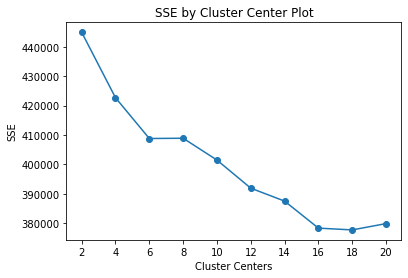

In [11]:
def find_optimal_clusters(df, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(df).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(text, 20)

In [13]:
clusters = MiniBatchKMeans(n_clusters=16, init_size=1024, batch_size=2048, random_state=20).fit_predict(text)

C:\Users\schre\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\schre\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\schre\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\schre\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warn

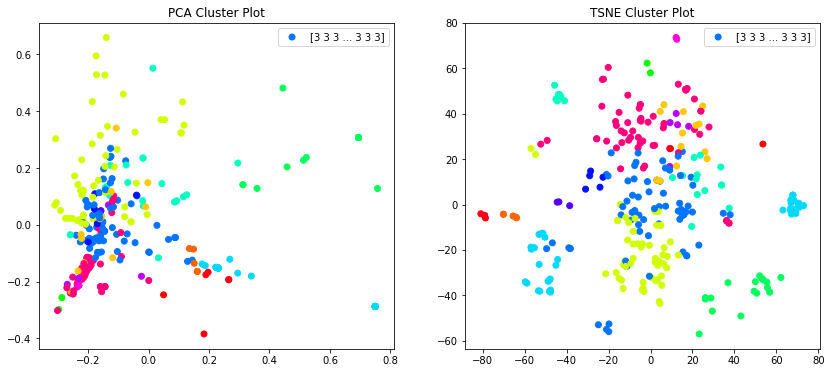

In [41]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset, label=clusters)
    ax[0].set_title('PCA Cluster Plot')
    ax[0].legend()
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset, label=clusters)
    ax[1].set_title('TSNE Cluster Plot')
    ax[1].legend()
    
    
plot_tsne_pca(text, clusters)

In [35]:
def plot_tsne_pca(data, labels, sizelist, cmap='tab10'):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), sizelist, replace=False)

    pca = PCA(n_components=2).fit_transform(data[max_items, :].todense())
    tsne = TSNE().fit_transform(PCA(n_components=1).fit_transform(data[max_items, :].todense()))

    idx = np.random.choice(range(pca.shape[0]), sizelist, replace=False)
    label_subset = labels[max_items]
    #label_subset = [cm.hsv(i / max_label) for i in label_subset[idx]]
    f, ax = plt.subplots(1, 2, figsize=(20, 6))

    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset, cmap=cmap)
    ax[0].set_title('PCA Cluster Plot')

    sc = ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset, cmap=cmap)
    ax[1].set_title('TSNE Cluster Plot')
    ax[1].legend(*sc.legend_elements(), title='clusters')


plot_tsne_pca(text, clusters, sizelist)

NameError: name 'sizelist' is not defined

In [17]:
# Add clusters label to DF
df['clusters'] = clusters
df.head()

,description_of_requirement,level_2_category,level_3_category,co_bus_size_determination,business_rule_tier,contract_name,req,clusters
0,DHS BULK CLOSE OUT,Capability As a Service,Network,OTHER THAN SMALL BUSINESS,TIER 2,SCHEDULE 70 - INFORMATION TECHNOLOGY,DHS BULK CLOSE OUT Capability As a Service Net...,3
1,ITAS SUPPORT SERVICES,IT Professional Services,IT Management,SMALL BUSINESS,TIER 2,SCHEDULE 70 - INFORMATION TECHNOLOGY,ITAS SUPPORT SERVICES IT Professional Services...,3
2,WIRELESS SERVICE,IT Professional Services,Network,OTHER THAN SMALL BUSINESS,TIER 2,SCHEDULE 70 - INFORMATION TECHNOLOGY,WIRELESS SERVICE IT Professional Services Netw...,3
3,PERFORMANCE PERIOD: 10/24/18-09/30/19DOJ FBI ...,Capability As a Service,Network,OTHER THAN SMALL BUSINESS,TIER 2,SCHEDULE 70 - INFORMATION TECHNOLOGY,PERFORMANCE PERIOD: 10/24/18-09/30/19DOJ FBI ...,9
4,IGF::OT::IGF VERIZON WIRELESS FY19 RMB/ IOD,Capability As a Service,Network,OTHER THAN SMALL BUSINESS,TIER 2,SCHEDULE 70 - INFORMATION TECHNOLOGY,IGF::OT::IGF VERIZON WIRELESS FY19 RMB/ IOD Ca...,3


In [18]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(text, clusters, tfidf.get_feature_names(), 10)

C:\Users\schre\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


MemoryError: Unable to allocate 31.5 GiB for an array with shape (528640, 8000) and data type float64